<a href="https://colab.research.google.com/github/Marc-Chiu/Introduction2MLSpring2022/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# imports needed
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn.model_selection import KFold
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import sys

In [3]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# download data
ROOT = '.data'
train_data = datasets.CIFAR10(root = ROOT, 
                              train = True, 
                              download = True)

Files already downloaded and verified


In [5]:
# Compute means and standard deviations along the R,G,B channel

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

In [6]:
print(means)

[0.49139968 0.48215841 0.44653091]


In [7]:
 # transform data, rotate, flip, crop, normalize 
train_transforms = transforms.Compose([
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 2),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

In [8]:
train_data = datasets.CIFAR10(ROOT, 
                              train = True, 
                              download = True, 
                              transform = train_transforms)

test_data = datasets.CIFAR10(ROOT, 
                             train = False, 
                             download = True, 
                             transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
print(len(train_data))
print(len(test_data))

50000
10000


In [10]:
def plot_images(images, labels, classes, normalize = False):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (10, 10))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

In [11]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

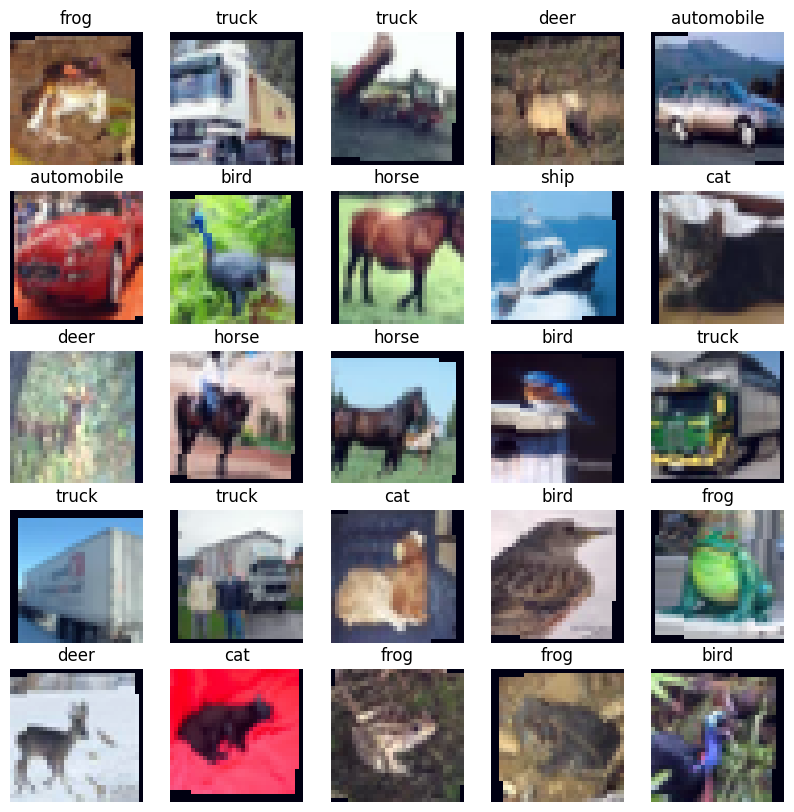

In [12]:
plot_images(images, labels, classes, normalize = True)

In [13]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [14]:
# Create data loaders for train_data, valid_data, test_data
# Use batch size 256
batch_size= 256
test_iterator = torch.utils.data.DataLoader(test_data,batch_size=batch_size ,shuffle=False)

num_epochs=10
batch_size=256
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)

In [15]:
# for model definition
import torch
import torch.nn as nn
import torch.nn.functional as F


# residual blocks
# conv layer -> batch norm -> conv layer -> batch norm -> skip connection -> relu
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 96, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 156, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 350, num_blocks[3], stride=2)
        self.linear = nn.Linear(350*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [16]:
# number of paramters
OUTPUT_DIM = 10
model = ResNet18()
pytorch_total_params = sum(p.numel() for p in model.parameters())


4999718


In [37]:
print('Total number of parameters',pytorch_total_params)

Total number of parameters 4999718


In [38]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track

In [17]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [18]:
# intialize paremeters using kaiming intialize
def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                nn.init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant(m.weight, 1)
            nn.init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal(m.weight, std=1e-3)
            if m.bias[0]:
                nn.init.constant(m.bias, 0)

In [ ]:
init_params(model)

In [20]:
# opitmizer and loss functions
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)
print(torch.version.cuda)
print(device)


11.8
cuda


In [21]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [22]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [23]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [25]:
# train your model here for 25 epochs. 
# Print out training and validation loss/accuracy of the model after each epoch
# Keep track of the model that achieved best validation loss thus far.

EPOCHS = 10

PATH = 'checkpoint.pth'
min_loss=sys.maxsize
fold = 0

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_data)))):
    print("Fold", fold)
    fold += 1

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_iterator = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
    valid_iterator = DataLoader(train_data, batch_size=batch_size, sampler=test_sampler)

    for i in range(EPOCHS):
      loss_tr,acc_tr=train(model,train_iterator,optimizer,criterion,device)
      loss_val,acc_val=evaluate(model,valid_iterator,criterion,device)

      print('Epoch ',i,'Training Loss ',loss_tr)
      print('Epoch ',i,'Training accuracy ',acc_tr)
      print('Epoch ',i,'Validation Loss ',loss_val)
      print('Epoch ',i,'Validation accuracy ',acc_val)
      if loss_val<min_loss :
        min_loss=loss_val
        min_epoch=i
        torch.save({
              'epoch': i,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': loss_val,
              'acc' : acc_val
              }, PATH)



Fold 0
Epoch  0 Training Loss  1.5443517599895502
Epoch  0 Training accuracy  0.41030553343949044
Epoch  0 Validation Loss  1.3363596946001053
Epoch  0 Validation accuracy  0.519140625
Epoch  1 Training Loss  1.1024308990521037
Epoch  1 Training accuracy  0.5974820859872612
Epoch  1 Validation Loss  1.0680017217993736
Epoch  1 Validation accuracy  0.60791015625
Epoch  2 Training Loss  0.8949683923630198
Epoch  2 Training accuracy  0.680359275477707
Epoch  2 Validation Loss  1.0170771673321723
Epoch  2 Validation accuracy  0.65029296875
Epoch  3 Training Loss  0.7598249703455883
Epoch  3 Training accuracy  0.7304936305732485
Epoch  3 Validation Loss  0.943458366394043
Epoch  3 Validation accuracy  0.67802734375
Epoch  4 Training Loss  0.6626957939688567
Epoch  4 Training accuracy  0.7690087579617835
Epoch  4 Validation Loss  0.7473858147859573
Epoch  4 Validation accuracy  0.74169921875
Epoch  5 Training Loss  0.59658887242056
Epoch  5 Training accuracy  0.7928941082802548
Epoch  5 Vali

In [26]:
# Load the best performing model, evaluate it on the test dataset, and print test accuracy.
PATH = 'checkpoint.pth'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_epoch = checkpoint['epoch']
best_loss = checkpoint['loss']
loss_test,acc_test=evaluate(model,test_iterator,criterion,device)
print('Test Loss ',loss_test)
print('Test accuracy % ',acc_test*100)
# Also, print out the confusion matrox.


Test Loss  0.3584940489381552
Test accuracy %  89.47265625


In [27]:
def get_predictions(model, iterator, device):

    model.eval()

    labels = []
    probs = []

    # Fill code here.
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            labels.append(y)
            probs.append(y_pred)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

   
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [28]:
labels, probs = get_predictions(model, test_iterator, device)

In [29]:
pred_labels = torch.argmax(probs, 1)

In [30]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels.cpu(), pred_labels.cpu());
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)

In [31]:
print(pred_labels)

tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0')


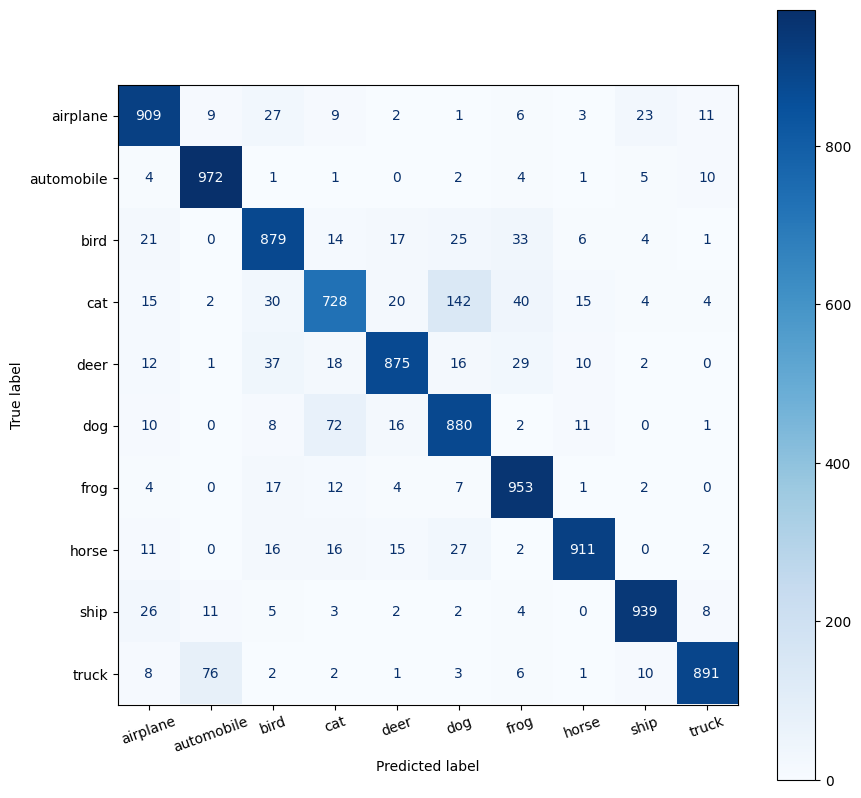

In [32]:
plot_confusion_matrix(labels,pred_labels,classes) 